In [19]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

from multiprocessing import Pool

%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

In [20]:
import lightkurve as lk
search = lk.search_lightcurvefile('2568888')
print(search)
files = search.download_all()
lc = files.PDCSAP_FLUX.stitch()
lc = lc.remove_outliers().remove_nans()

pg = lc.to_periodogram(method='lombscargle', normalization='psd', minimum_frequency=1, maximum_frequency=300)
#feel free to play around with smoothing here using the filter width
pg_smooth = pg.smooth(method='boxkernel', filter_width=1).power

power = np.array(pg.power) * 10**12
pg_smooth = np.array(pg_smooth) * 10**12
nu = np.array(pg.frequency)



SearchResult containing 10 data products.

 #     observation     target_name            productFilename            distance
--- ----------------- ------------- ------------------------------------ --------
  0  Kepler Quarter 8 kplr002568888 kplr002568888-2011073133259_llc.fits      0.0
  1  Kepler Quarter 9 kplr002568888 kplr002568888-2011177032512_llc.fits      0.0
  2 Kepler Quarter 10 kplr002568888 kplr002568888-2011271113734_llc.fits      0.0
  3 Kepler Quarter 11 kplr002568888 kplr002568888-2012004120508_llc.fits      0.0
  4 Kepler Quarter 12 kplr002568888 kplr002568888-2012088054726_llc.fits      0.0
  5 Kepler Quarter 13 kplr002568888 kplr002568888-2012179063303_llc.fits      0.0
  6 Kepler Quarter 14 kplr002568888 kplr002568888-2012277125453_llc.fits      0.0
  7 Kepler Quarter 15 kplr002568888 kplr002568888-2013011073258_llc.fits      0.0
  8 Kepler Quarter 16 kplr002568888 kplr002568888-2013098041711_llc.fits      0.0
  9 Kepler Quarter 17 kplr002568888 kplr002568888-20131

In [22]:
def model(theta,nu=nu):
    nwh,a1,a2,a3,b1,b2,b3, nu_max1,sig_nu1,amp1, nu_max2,sig_nu2,amp2= theta
    att = atten()
    gau1 = att*amp1*np.exp(-(nu-nu_max1)**2/(2*sig_nu1**2))
    gau2 = att*amp2*np.exp(-(nu-nu_max2)**2/(2*sig_nu2**2))
    model = nwh + att* (a1/(1+(nu/b1)**4) + a2/(1+(nu/b2)**4) + a3/(1+(nu/b3)**4))
    model = model + gau1 + gau2
    return model

def atten(nu=nu):
    #283.212 is the attenuation frequency of long cadence
    atten  = (np.sinc((nu)/(2*283.212)))**2
    return atten

def lnlike(theta, x, y, yerr):
    #this should be fine but dependent on what we chose yerr to be
    Lnlike = -1/2 * np.sum(((y - model(theta, nu))/yerr)**2)
    return Lnlike

def lnprior(theta):
    nwh, a1, a2, a3, b1, b2, b3, nu_max1,sig_nu1,amp1, nu_max2,sig_nu2,amp2= theta
    #this is gross surely there is a way to make this look nicer
    #priors taken to be small range about the values given in 2568888 paper
    if (130 < nwh < 160) and (100000 < a1 < 110000) and (22000 < a2 < 23000) and (2000 < a3 < 5000) and (1 < b1 < 5) and (5 < b2 < 8) and (10 < b3 < 30)and (6 < nu_max1 < 8) and (0.5< sig_nu1 < 1.5) and (40000< amp1 < 60000) and (15.5 < nu_max2 < 17.5) and (3< sig_nu2 < 5) and (5000< amp2 <15000):
        return 0.0
    else:
        return -np.inf
    
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if (lp == -np.inf):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) 


def main(p0,nwalkers,niter,ndim,lnprob,data):
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

        print("Running burn-in...")
        p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
        sampler.reset()

        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

        return sampler, pos, prob, state
    
    
def plotter(sampler,nu=nu,power=power, pg_smooth = pg_smooth):
    plt.ion()
    plt.plot(nu,power,label='Power')
    plt.plot(nu,pg_smooth)
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(nu, model(theta, nu), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel(r'$\nu$')
    plt.ylabel('Power')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
    plt.savefig('me.pdf')


Text(0.5,1,'paper noise log')

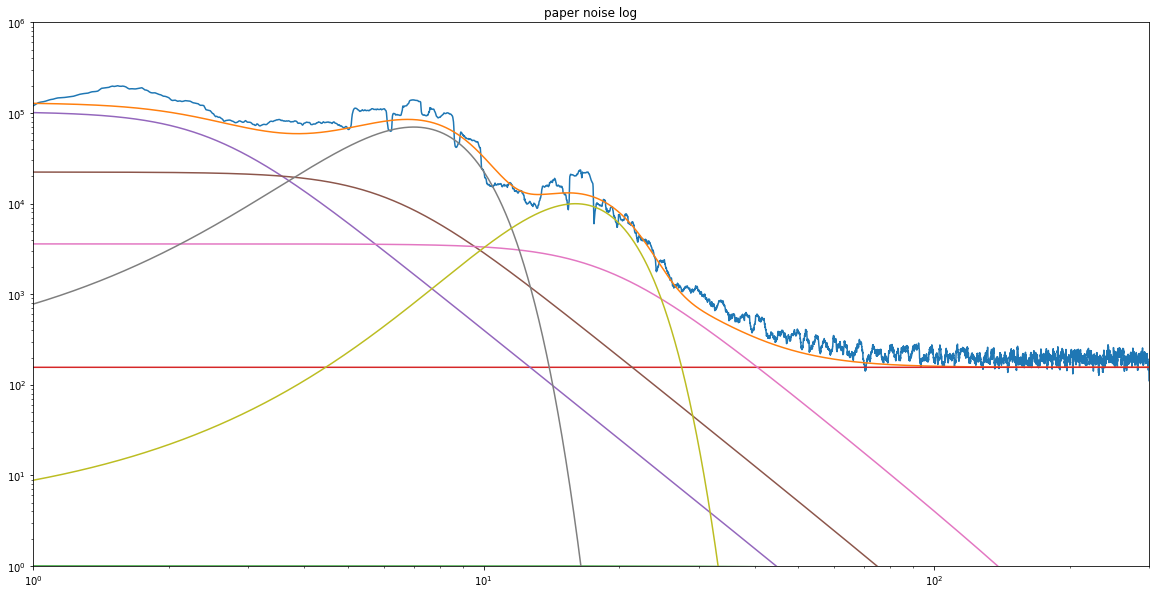

In [ ]:
initial = np.array([156, 103617, 22301, 3590., 2.5,6.2, 18.8, 7.,2,70000,16,4,10000])
nwh, a1, a2, a3, b1, b2, b3, nu_max1,sig_nu1,amp1, nu_max2,sig_nu2,amp2 = initial
init_model = model(initial)
plt.plot(nu,pg_smooth,label='Power')
plt.plot(nu,init_model,label='Their best fit parameter models Model')
att = atten()
plt.plot(nu,att)
plt.plot(nu,nwh*np.ones_like(nu))
plt.plot(nu, att * (a1/(1+(nu/b1)**4)))
plt.plot(nu, att * (a2/(1+(nu/b2)**4)))
plt.plot(nu, att * (a3/(1+(nu/b3)**4)))


plt.plot(nu,att*amp1*np.exp(-(nu-nu_max1)**2/(2*sig_nu1**2)))
plt.plot(nu,att*amp2*np.exp(-(nu-nu_max2)**2/(2*sig_nu2**2)))


plt.xscale('log')
plt.yscale('log')
plt.xlim(1,300)
plt.ylim(1,10**6)
plt.title('paper noise log')

# plt.savefig('paper_noise_log.pdf')

# plt.figure()
# init_model = model(initial)
# plt.plot(nu,power,label='Power')
# plt.plot(nu,init_model,label='Their best fit parameter models Model')
# plt.plot(nu,atten())
# plt.plot(nu,156*np.ones_like(nu))
# plt.xlim(1,300)
# plt.title('paper noise')

# plt.savefig('paper_noise.pdf')

# plt.figure()
# plt.plot(nu,power/init_model,label='Power')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1,300)
# plt.title('paper normalised log')

# plt.savefig('paper_normalised_log.pdf')

# plt.figure()
# plt.plot(nu,power/init_model,label='Power')

# plt.xlim(4,20)
# plt.title('paper normalised')

# plt.savefig('paper_normalised.pdf')

In [ ]:
#not sure about this error probably doesnt work well for a wide range of values as we have here
Perr = 1e-6
data = (nu, pg_smooth,Perr)
nwalkers = 500
niter = 1000
initial = np.array([156, 103617, 22301, 3590., 2,6.2, 18.8, 7.8,1.5,50000,17,4,10000])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


  0%|          | 0/100 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 41%|████      | 41/100 [00:33<00:53,  1.10it/s]

In [ ]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(nu,power,label='Power')
plt.plot(nu,best_fit_model,label='Highest Likelihood Model')

plt.xscale('log')
plt.yscale('log')
plt.title('bestfit noise log')
plt.xlim(1,300)
plt.savefig('bestfit_noise_log.pdf')


plt.figure()
plt.plot(nu,power,label='Power')
plt.plot(nu,best_fit_model,label='Highest Likelihood Model')

plt.title('bestfit noise')
plt.xlim(1,300)
plt.savefig('bestfit_noise.pdf')
print ('Theta max: ',theta_max)